In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 
from pandas.plotting import register_matplotlib_converters 
from statsmodels.tsa.seasonal import STL

In [2]:
path = "household_power_consumption.txt"
df = pd.read_csv(path,delimiter=";",dtype="str")

#Combine date and time
df["datetime"] = pd.to_datetime(df["Date"]+" "+df["Time"])
#Convert other columns to numeric
df["Global_active_power"] = pd.to_numeric(df["Global_active_power"],errors="coerce")
df["Global_reactive_power"] = pd.to_numeric(df["Global_reactive_power"],errors="coerce")
df["Voltage"] = pd.to_numeric(df["Voltage"],errors="coerce")
df["Global_intensity"] = pd.to_numeric(df["Global_intensity"],errors="coerce")
df["Sub_metering_1"] = pd.to_numeric(df["Sub_metering_1"],errors="coerce")
df["Sub_metering_2"] = pd.to_numeric(df["Sub_metering_2"],errors="coerce")
df["Sub_metering_3"] = pd.to_numeric(df["Sub_metering_3"],errors="coerce")

#Mark nan-rows
df["nan_rows"] = 0
df.loc[df.isna().any(axis=1),"nan_rows"] = 1
#Timestamp rounded to floor hour

df["timestamp"] = df["datetime"].dt.floor("H")

df.head()

C:\Users\valta\AppData\Local\Temp\ipykernel_11592\3791000578.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["datetime"] = pd.to_datetime(df["Date"]+" "+df["Time"])
C:\Users\valta\AppData\Local\Temp\ipykernel_11592\3791000578.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["timestamp"] = df["datetime"].dt.floor("H")


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,datetime,nan_rows,timestamp
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,0,2006-12-16 17:00:00
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,0,2006-12-16 17:00:00
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,0,2006-12-16 17:00:00
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,0,2006-12-16 17:00:00
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,0,2006-12-16 17:00:00


In [3]:
df.set_index("datetime", inplace=True)
df.sort_index(inplace=True)

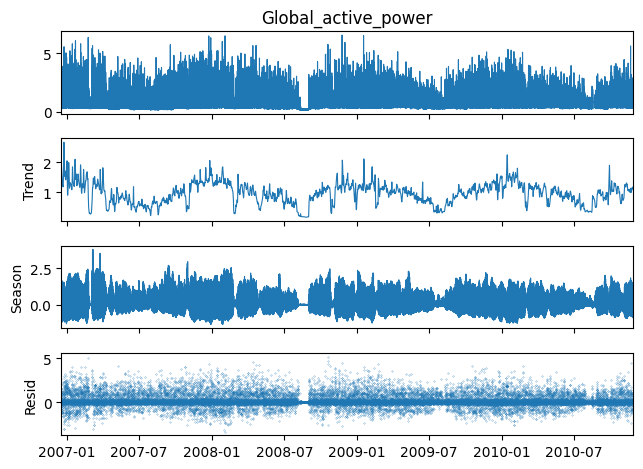

In [ ]:
y = df["Global_active_power"].resample("h").mean().interpolate("time").dropna() 
# STL 
stl = STL(y, period=24, robust=True) 
res = stl.fit() 
fig = res.plot()
for ax in fig.axes:
    for line in ax.get_lines():
        line.set_linewidth(0.8)      # thinner lines
        line.set_markersize(0.2)       # smaller markers
plt.tight_layout()
plt.show()

season
Autumn    1.134610
Spring    1.103194
Summer    0.726682
Winter    1.417623
Name: Global_active_power, dtype: float64


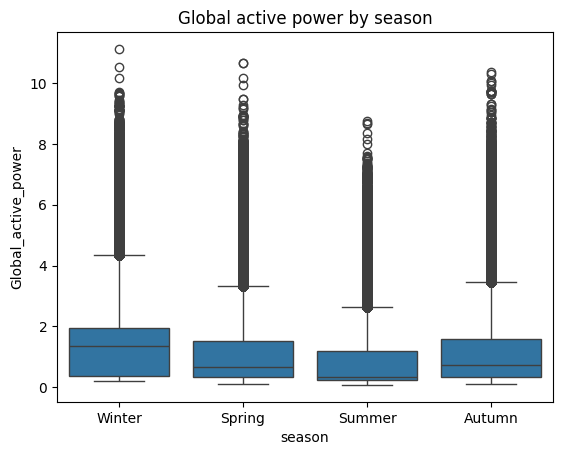

In [13]:
# Luodaan sarake kuukaudelle
df["month"] = df.index.month

# Määritellään vuodenajat (voit säätää rajoja halutessasi)
def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

df["season"] = df["month"].apply(get_season)

# Esim. piirrä keskiarvot vuodenajoittain
seasonal_means = df.groupby("season")["Global_active_power"].mean()
print(seasonal_means)

sns.boxplot(x="season", y="Global_active_power", data=df, order=["Winter","Spring","Summer","Autumn"])
plt.title("Global active power by season")
plt.show()


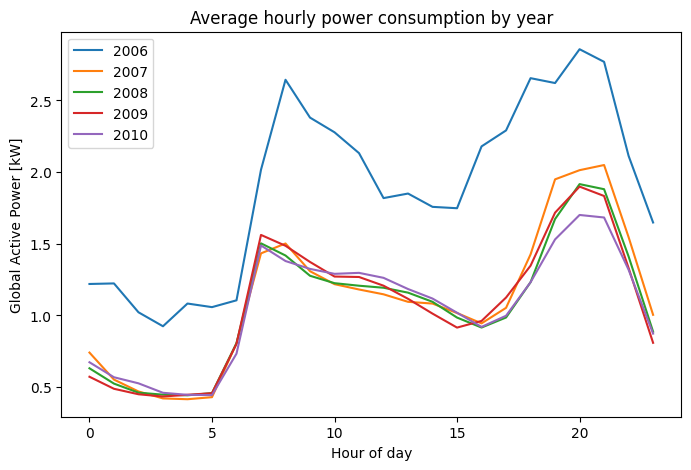

In [14]:
df["year"] = df.index.year
df["hour"] = df.index.hour

daily_pattern = df.groupby(["year", "hour"])["Global_active_power"].mean().reset_index()

plt.figure(figsize=(8,5))
for year in sorted(daily_pattern["year"].unique()):
    subset = daily_pattern[daily_pattern["year"] == year]
    plt.plot(subset["hour"], subset["Global_active_power"], label=str(year))
plt.legend()
plt.title("Average hourly power consumption by year")
plt.xlabel("Hour of day")
plt.ylabel("Global Active Power [kW]")
plt.show()


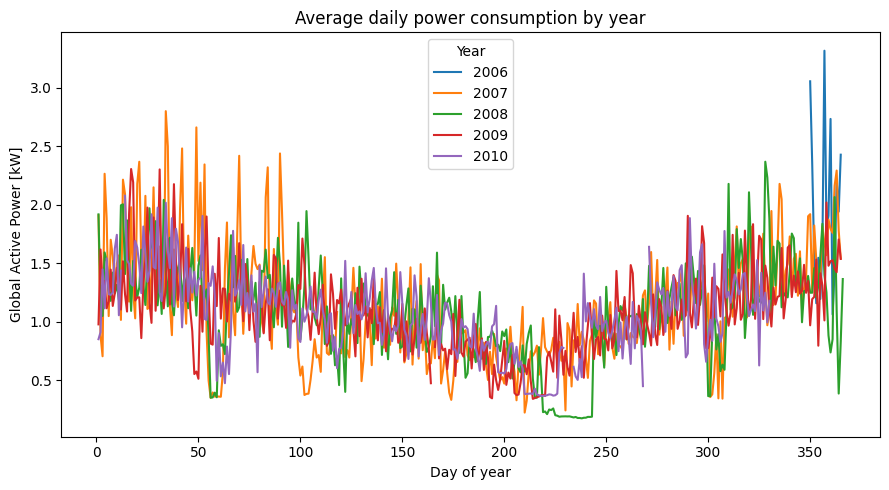

In [16]:
df["year"] = df.index.year
df["day_of_year"] = df.index.dayofyear

# Päivittäinen keskiarvo (vuosi + vuodenpäivä)
daily_pattern = df.groupby(["year", "day_of_year"])["Global_active_power"].mean().reset_index()

plt.figure(figsize=(9,5))
for year in sorted(daily_pattern["year"].unique()):
    subset = daily_pattern[daily_pattern["year"] == year]
    plt.plot(subset["day_of_year"], subset["Global_active_power"], label=str(year))

plt.legend(title="Year")
plt.title("Average daily power consumption by year")
plt.xlabel("Day of year")
plt.ylabel("Global Active Power [kW]")
plt.tight_layout()
plt.show()


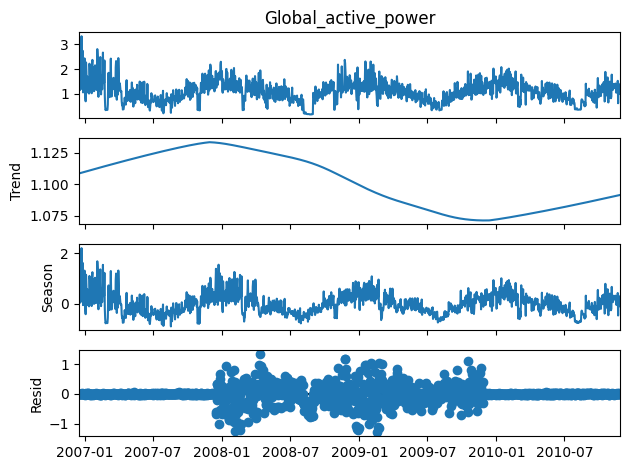

In [15]:
# Esim. vuosittainen seasonality (päivädata)
y_daily = df["Global_active_power"].resample("D").mean().interpolate("time")

stl = STL(y_daily, period=365, robust=True)
res = stl.fit()

fig = res.plot()
plt.tight_layout()
plt.show()
